In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from einops import rearrange
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split

from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

MODEL = "moirai-moe"  # model name: choose from {'moirai', 'moirai-moe'}

In [77]:
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT = 20  # prediction length: any positive integer
CTX = 20  # context length: any positive integer
PSZ = 8  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
TEST = 100  # test set length: any positive integer
MODEL = ["Salesforce/moirai-1.1-R-small", "Salesforce/moirai-moe-1.0-R-small"]

In [42]:
COLS = ["mean_swe", "mean_pr", "mean_tair", "mean_vs", "mean_srad", "mean_hum"]

total length: 240
time frequency: 0 days 01:00:00


<Axes: >

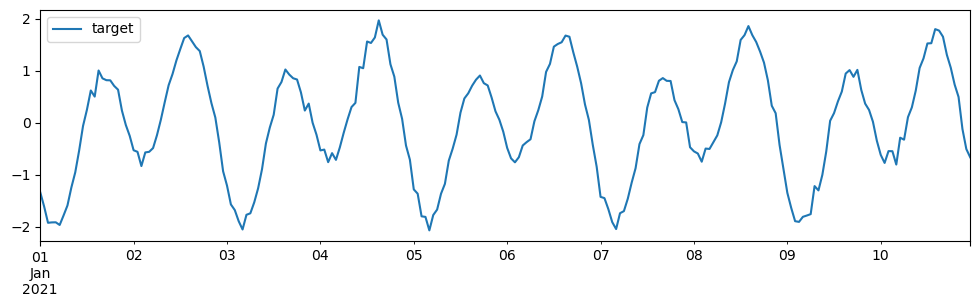

In [4]:
# Load dataframe and plot it
url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)

df = pd.read_csv(url, index_col=0, parse_dates=True)
df = df[df["item_id"] == "A"].drop(columns=["item_id"])
print(f"total length: {df.shape[0]}")
print(f"time frequency: {df.index.diff()[1]}")
df.plot(figsize=(12, 3))

In [8]:
df

,target
2021-01-01 00:00:00,-1.3378
2021-01-01 01:00:00,-1.6111
2021-01-01 02:00:00,-1.9259
2021-01-01 03:00:00,-1.9184
2021-01-01 04:00:00,-1.9168
...,...
2021-01-10 19:00:00,0.7328
2021-01-10 20:00:00,0.4957
2021-01-10 21:00:00,-0.1209
2021-01-10 22:00:00,-0.5072


In [87]:
data_path = "model_ready_huc170103010101.csv"
df = pd.read_csv(data_path, index_col=0, parse_dates=True)

In [91]:
df = df[COLS]
df.columns

Index(['mean_swe', 'mean_pr', 'mean_tair', 'mean_vs', 'mean_srad', 'mean_hum'], dtype='object')

In [78]:
ds = PandasDataset(dict(df))

grouper = MultivariateGrouper(len(ds))
multivar_ds = grouper(ds)

train, test_template = split(
    multivar_ds, offset=-TEST
)

test_data = test_template.generate_instances(
    prediction_length=PDT,
    windows=TEST // PDT,
    distance=PDT
)

In [79]:
model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(MODEL[1]),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=len(ds),
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )

In [80]:
predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

In [81]:
inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)

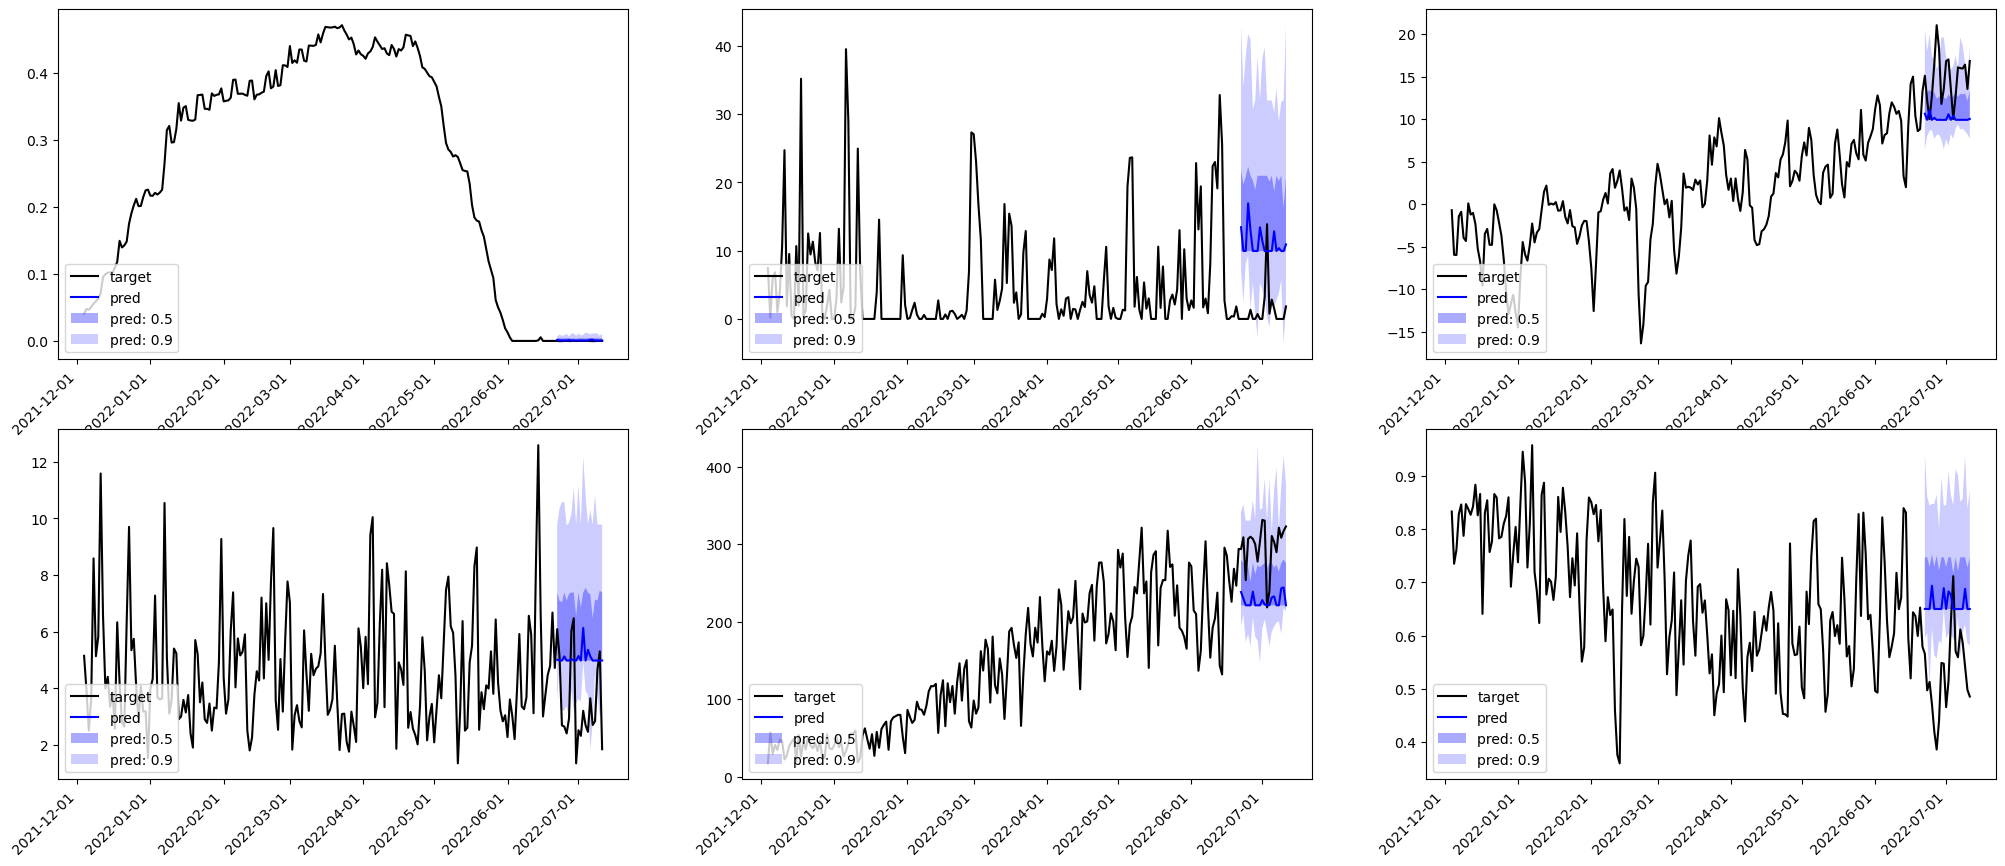

In [82]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
for i, ax in enumerate(axes.flatten()):
    plot_single(
        inp,
        label,
        forecast,
        context_length=200,
        intervals=(0.5, 0.9),
        dim=i,
        ax=ax,
        name="pred",
        show_label=True,
    )